# Analytic Inverse Kinematics of the leg in the plane and trajectory generation

We will continue to use the 2D version of the finger, where the first degree of freedom of the robot is constrained to stay at 0 position. 

<img src="./2d_robot_model.png" width="300">

As we have seen last week, the forward kinematics of the leg could be written such that the pose of the foot F (i.e. its position and orientation) with respect to frame {S} is
 $$\begin{bmatrix}\cos(\theta_1+\theta_2) & -\sin(\theta_1+\theta_2)& l_2\sin(\theta_1+\theta_2) + l_1\sin\theta_1 + l_0\\
\sin(\theta_1+\theta_2) & \cos(\theta_1+\theta_2) & -l_2\cos(\theta_1+\theta_2)  - l_1\cos\theta1\\
0 & 0 & 1
 \end{bmatrix}$$
 
 Now we are asking the following question: given a desired $(x_{des},y_{des})$ position for the foot, can we find configurations $\theta_1$, $\theta_2$ that would realize this?
 
The goal of an analytic inverse kinematics algorithm is to find all (if any) possible solutions to this problem.

## Reachable workspace

The distance between the frame {H} and the foot {F} is noted $l_{des} = \sqrt{(x_{des} - l_0)^2 + y_{des}^2}$

The leg has 2 DOFs. The furthest it can reach is around a circle of center {H} and radius $l_1 + l_2$. For any point on this radius, we necessarily have the leg fully extended and therefore $\theta_2 = 0$.

When $\theta_2$ is not 0, the leg is folded and the distance from ${H}$ to ${F}$ can be made arbitrary between $0$ and $l_1 + l_2$, i.e. $0 \leq l_{des} \leq l_1+l_2$ because $l_1 = l_2$, the robot can then reach any position inside the circle of radius $l_1 + l_2$.

## Analytic inverse kinematics
We need to find a way to relate the angles to the position of the leg. In our case, we will consider the influence of the joint angles on the leg lenght and then on its orientation.
### The leg length
Consider the triangle formed by $l_{des}$, $l_1$ and $l_2$. Using the law of cosines we see that
$$l_{des}^2 - l_1^2 - l_2^2 = -2l_1 l_2 \cos(\pi - \theta_2)$$
which gives
$$\cos(\theta_2) = \frac{l_{des}^2 - l_1^2 - l_2^2}{2l_1 l_2}$$

we have then two possible choice for $\theta_2 = \pm \arccos(\frac{l_{des}^2 - l_1^2 - l_2^2}{2l_1 l_2})$. We will denote $\theta_2^+$ the positive solution (when the leg is bent with the knee pointing left) and $\theta_2^-$ the other solution (with the knee pointing toward the right).

### The leg orientation
We have seen that $\theta_2$ defines the distance from {H} to {F}. $\theta_1$ will then define the position of the foot on the circle defined by the leg length. First we define some helpful quantities.
The angle between the line going from ${H}$ to ${F}$ and the horizontal line going from ${H}$ to the right direction is $$\beta = \arctan2(y_{des}, x_{des} - l_0)$$
and the angle between $l_1$ and the {H}-{F} line is (using the law of cosines)
$$\alpha = \arccos(\frac{-l_2^2 + l_1^2 + l_{des}^2}{2l_1l_{des}})$$

We need to consider two distinct cases:

1. $\theta_2^+$: in this case, we have $\theta_1^+ = \pi/2 - \alpha + \beta$
2. $\theta_2^-$: in this case, we have $\theta_1^- = \pi/2 + \alpha + \beta$

In [1]:
#setup nice plotting (use widget instead of notebook in the command below if you use jupyter lab)
%matplotlib notebook

# we import useful libraries
import time
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt

# we import the helper class / we will use a similar class to work with the real robot
from nyu_finger_simulator import NYUFingerSimulator

In [2]:
# here we define the global variables for the robot size
l0 = 0.3
l1 = 0.16
l2 = 0.16

def translate(vector):
    """
    returns an homogenous transform for a 2D translate of vector
    """
    transform = np.eye(3)
    transform[0:2,2] = vector
    return transform

def rotate(angle):
    """
    returns an homogenous transform for a 2D rotation of angle
    """
    transform = np.eye(3)
    transform[0,0] = np.cos(angle)
    transform[0,1] = -np.sin(angle)
    transform[1,0] = np.sin(angle)
    transform[1,1] = np.cos(angle)
    
    return transform

def forward_kinematics(theta1, theta2):
    """
    This function computes the 2D forward kinematics of the robot
    theta1 and theta2 correspond to joint angles as described in the figure above
    it returns the pose (3x3 homogenous matrix) of the foot with respect to frame {F}
    """
    
    transform = translate(np.array([l0,0])).dot(rotate(theta1)).dot(translate(np.array([0,-l1]))).dot(rotate(theta2)).dot(translate(np.array([0,-l2])))
    
    return transform

# Questions:
1. Write an inverse kinematics function that takes a desired x,y position for the foot and returns a list of all possible solutions (if any) in terms of joint angles for $\theta_1$ and $\theta_2$.

2. Test you function using the test_IK function. It will generate a random desired (x,y) position for the foot, then compute the IK and verify that all the returned solutions are correct by computing the forward kinematics solution of each and verifying that $\textrm{ForwardKinematics}(\textrm{InverseKinematics}(x_{des}, y_{des})) = (x_{des},y_{des})$ 

In [3]:
def inverse_kinematics(x,y):
    """
    inverse kinematics function
    input (x,y) position of the foot
    output a list of 2D vectors which are possible solutions to the problem 
    (the list is empty if there are no solutions)
    """
    l_des = np.sqrt((x-l0)**2 + y**2)


    if l_des <= (l1+l2):
        
        theta2 = np.arccos((l_des**2 - l1**2 - l2**2)/(2*l1*l2))
        beta = np.arctan2(y, x - l0)
        alpha = np.arccos((l1**2 - l2**2+l_des**2)/(2*l1*l_des))
    
  
        return [[(((np.pi)/2) - alpha + beta), theta2], [(((np.pi)/2) + alpha + beta), -1*theta2]]
    else:
        return []
    

def test_IK(num_tests = 10):
    """
    This function is used to test the inverse kinematics function
    it generates num_tests random (x,y) locations and try to solve them
    it prints potential errors
    """
    num_errors = 0
    num_infeasible = 0
    points = np.zeros([num_tests, 2])
    colors = np.zeros([num_tests, 1])
    
    for i in range(num_tests):
        # we generate a random (x,y) location in a box of l1+l2 around {H}
        x = np.random.random_sample()*(l1+l2)*2 - (l1+l2) + l0
        y = np.random.random_sample()*(l1+l2)*2 - (l1+l2)

        # we save the point for plotting
        points[i,0] = x
        points[i,1] = y
        
        solutions = inverse_kinematics(x,y)
        
        l_des = np.sqrt((x-l0)**2 + y**2)
        if l_des > l1+l2:
            num_infeasible += 1
            colors[i] = 1
            
        if not solutions:
            # we did not find solutions
            # check if this is correct
            if l_des <= l1+l2:
                print(f'ERROR: IK did not find a solution while there should be at least one, for x={x} and y={y}')
                num_errors +=1
        else:
            for sol in solutions:
                pose = forward_kinematics(sol[0], sol[1])
                x_ik = pose[0,2]
                y_ik = pose[1,2]
                error = np.sqrt((x-x_ik)**2 + (y-y_ik)**2)
                if error > 0.001:
                    print(f'solution {sol} did not find the correct IK solution x_des = {x}, y_des = {y} but found x_ik = {x_ik} and y_ik = {y_ik}')        
                    num_errors +=1
                    
    print(f'there were {num_tests-num_infeasible} feasible samples and {num_infeasible} infeasible ones')
    if num_errors > 0:
        print(f'there were {num_errors} errors detected')
    else:
        print('CONGRATS: no errors were detected!')
        
test_IK(10000)

there were 7954 feasible samples and 2046 infeasible ones
CONGRATS: no errors were detected!


# Trajectory generation

Once we know where we want to move the foot and the associated goal positions for $\theta_1$ and $\theta_2$, we need to control the robot and make sure it goes there. It is generally not a good idea to just send the desired joint positions to the PD controller because if they are too far from the actual positions, the error will be large and a large torque will be applied on each motor. This will likely create a very jerky movement, potentially creating a very large torque on each joint which could damage the robot, its motors, etc.

## Linear interpolation between initial and goal position
Instead, we would like to create a nice trajectory that moves the robot from its current position to the desired goal position. One simple way to do that is to linear interpolate the desired joint angles from the current ones to the goal ones. For example, for each joint we could set
$$\theta_{des}(s) = \theta_{init} + s (\theta_{goal} - \theta{init})$$
where $s \in [0,1]$. Doing so, when $s=0$ we get $\theta_{des} = \theta_{init}$ (i.e. the joint angle when we started the movement. When $s=1$, we get $\theta_{des} = \theta{goal}$ (i.e. the position where we would like to end up). For any $s$ in between, we will generate a line segment between those two positions.

## Time parametrization of the trajectory
### Linear time parametrization
Now we would like to change $s$ as a function of time. It means that as $t$ increases from $0$ (when we start the controller) to some $T$ (which is the desired time we would like the motion to last) we will get a desired position $\theta_{des}$ and also a desired velocity $\dot{\theta}_{des}$ for the joint. We could simply set
$$ s(t) = \frac{t}{T}$$ which would lead to a trajectory of the form
$$\theta_{des}(t) = \theta_{init} + \frac{t}{T} (\theta_{goal} - \theta_{init})$$
with
$$\dot{\theta}_{des}(t) = \frac{1}{T} (\theta_{goal} - \theta_{init})$$
Doing this, we notice that the desired velocity would be constant, which is potentially problematic because we would start at rest (so the velocity should be 0) and would like to end our movement with 0 velocity.

### Time parametrization with velocity constraints
What we usually do is to parametrize $s$ as a polynomial of $t$ such that we can impose constraints on the desired velociy, acceleration, etc. Assume that $s(t)$ is some arbitrary function of time, we then have
$$\theta_{des}(t) = \theta_{init} + s(t) (\theta_{goal} - \theta_{init})$$,
$$\dot{\theta}_{des}(t) = \dot{s} (\theta_{goal} - \theta_{init})$$
and also $$\ddot{\theta}_{des}(t) = \ddot{s} (\theta_{goal} - \theta_{init})$$

If we want to for a desired velocity at the beginning and the end of the movement, we need to have $s(0) = 0$, $s(T) = 1$, $\dot{s}(0) = 0$ and $\dot{s}(T) = 0$. Since we have 4 constraints, we would need at least a polynomial of degree 3 to have enough parameters. Lets set 
$$s(t) = a_0 + a_1 t + a_2 t^2 + a_3 t^3$$
Then we have
$$\dot{s}(t) = a_1 + 2 a_2 t + 3 a_3 t^2$$
If we impose our constraints, we have $a_1 = 0$ because of $\dot{s}(0) = 0$ and $a_2 = -\frac{3}{2} a_3 T$ because $\dot{s}(T) = 0$. Then we find that $a_0=0$ because $s(0)=0$ and $a_3 = -\frac{2}{T^3}$. Putting everything together we find that to impose velocity constraints $$s(t) = \frac{3}{T^2}t^2 - \frac{2}{T^3}t^3$$
which implies that
$$\theta_{des}(t) = \theta_{init} + \left(\frac{3}{T^2}t^2 - \frac{2}{T^3}t^3\right) (\theta_{goal} - \theta_{init})$$
and
$$\dot{\theta}_{des}(t) = \left(\frac{6}{T^2}t - \frac{6}{T^3}t^2\right) (\theta_{goal} - \theta_{init})$$

### Time parametrization with acceleration and velocity constraints
In general, if we impose only velocity constraints, we might have non-zero accelerations which can be an issue when generating torques in the PD controller. We generally prefer also imposing acceleration constraints in addition to the other constraints, i.e.
$s(0) = 0$, $s(T) = 1$, $\dot{s}(0) = 0$, $\dot{s}(T) = 0$ and $\ddot{s}(0) = 0$, $\ddot{s}(T) = 0$
now that we imposed two new constraints, we will need to have a fifth order polynomial at least to satisfy them. 
Our polynomial is $$s(t) = a_0 + a_1 t + a_2 t^2 + a_3 t^3 + a_4 t^4 + a_5 t^5$$
The computations are as before (but we more equations) and we find $a_0 = a_1 = a_2 = 0$, $a_3 = \frac{10}{T^3}$, $a_4 = \frac{-15}{T^4}$ and $a_5 = \frac{6}{T^5}$.
This gives the following trajectory paramterized by time
$$\theta_{des}(t) = \theta_{init} + \left( \frac{10}{T^3} t^3 + \frac{-15}{T^4} t^4 + \frac{6}{T^5} t^5 \right) (\theta_{goal} - \theta_{init})$$
and
$$\dot{\theta}_{des}(t) = \left( \frac{30}{T^3} t^2 + \frac{-60}{T^4} t^3 + \frac{30}{T^5} t^4 \right) (\theta_{goal} - \theta_{init})$$
and the acceleration profile is
$$\ddot{\theta}_{des}(t) = \left( \frac{60}{T^3} t + \frac{-180}{T^4} t^2 + \frac{120}{T^5} t^3 \right) (\theta_{goal} - \theta_{init})$$

# Question:
1. Write a compute_trajectory function that takes as input argument the starting join position, the goal joint position, the movement duration and the current time t (between 0 and movement_duration) and returns the desired joint position and joint velocity. Use a time paramterization such that the velocity and acceleration are 0 at the beginning and end of the movement (i.e. using the fifth order polynomial above)

In [4]:
def compute_trajectory(th_init, th_goal, movement_duration, t):
    ###TO BE COMPLETED
    th = th_init + ((10*t**3/movement_duration**3)+(-15*t**4/movement_duration**4)+(6*t**5/movement_duration**5))*(th_goal - th_init)
    dth = ((30*t**2/movement_duration**3)+(-60*t**3/movement_duration**4)+(30*t**4/movement_duration**5))*(th_goal - th_init)
    return th, dth


# A complete reaching controller

# Question:
The code below generates 3 target ball locations (and display them). Their locations are in the variable ball_position (a list containing 2D vectors of x,y positions).

1. Modify the code below (our typical control loop with a PD controller) such that the robot moves from its current position to each ball successively. Use the inverse kinematics function to decide what the end joint angles should be and the trajectory generation function to compute inside the control loop the current desired positions and velocities of the robot joints. Use a total time for reaching movement of T=2 seconds (i.e. go from initial configuration to ball1 in 2 seconds, from ball1 to ball2 in 2 seconds, etc).

2. Use the plotting function below to plot the motion of the foot in space and the joint position/velocity trajectories. How well does it go through the targets?

        Ans. The robots pefectly goes through all the target balls as expected, taking full two seconds to 
             move from one location to another.

In [5]:
# we create a robot simulation
robot = NYUFingerSimulator()

# we reset the simulation to the initial position we want to move
robot.reset_state(np.array([0,0,0]))

# we simulate for 6 seconds
run_time = 6.
num_steps = int(run_time/robot.dt)

# the PD gains
P = np.array([3., 3., 3.])
D = np.array([0.3, 0.3, 0.3])

# to store information (for plotting later)
measured_positions = np.zeros([num_steps,3])
measured_velocities = np.zeros_like(measured_positions)
desired_torques = np.zeros_like(measured_positions)
desired_positions = np.zeros_like(measured_positions)
desired_velocities = np.zeros_like(measured_positions)
time = np.zeros([num_steps])

# the position of the foot
x_pos = np.zeros([num_steps,1])
y_pos = np.zeros([num_steps,1])

# here we create a list of ball positions and display them
ball_positions = [np.array([0.597,-0.056]), np.array([0.521,0.12]), np.array([0.3,-0.225])]
for ball in ball_positions:
    robot.add_ball(ball[0], ball[1])  


In [6]:

# the time to reach a goal
time_to_goal = 2.0

# we use this to know which target we are currently aiming
ball_number = 0
# we measure the internal time for one target movement
t = 0.

joint_waypoints = [inverse_kinematics(ball[0], ball[1])[0] for ball in ball_positions]

for i in range(num_steps):
    # get the current time and save it
    time[i] = robot.dt * i
    
    t = (i%2000)/1000
    
    # we get the position and velocities of the joints
    q, dq = robot.get_state()
    measured_positions[i,:] = q
    measured_velocities[i,:] = dq
    
    # save the current position of the foot using the FK function
    pose = forward_kinematics(q[1], q[2])
    x_pos[i] = pose[0,2]
    y_pos[i] = pose[1,2]
    
    
    # controller: TODO HERE IMPLEMENT YOUR CONTROLLER TO REACH ALL 3 TARGETS
    # compute the desired position and velocities for each joint separately using the compute_trajectory function
    # the goal here is to compute q_des and dq_des that the PD controller will follow
    # you will need some internal logic to decide which ball you are currently targetting, etc.
    
    if i < 2000:
        ball_number = 0
        th1, dth1 = compute_trajectory(0, joint_waypoints[0][0], time_to_goal, t) #theta1
        th2, dth2 = compute_trajectory(0, joint_waypoints[0][1], time_to_goal, t) #theta2
    elif i < 4000:
        ball_number = 1
        th1, dth1 = compute_trajectory(joint_waypoints[0][0], joint_waypoints[1][0], time_to_goal, t) #theta1
        th2, dth2 = compute_trajectory(joint_waypoints[0][1], joint_waypoints[1][1], time_to_goal, t) #theta2
    else:
        ball_number = 2
        th1, dth1 = compute_trajectory(joint_waypoints[1][0], joint_waypoints[2][0], time_to_goal, t) #theta1
        th2, dth2 = compute_trajectory(joint_waypoints[1][1], joint_waypoints[2][1], time_to_goal, t) #theta2
    q_des = np.array([0, th1, th2])
    dq_des = np.array([0, dth1, dth2])
    
    # we save the desired positions/velocities for later plotting 
    desired_positions[i,:] = q_des
    desired_velocities[i,:] = dq_des
    
    ##PD controller
    error = q_des - q # the position error for all the joints (it's a 3D vector)
    d_error = dq_des-dq # the velocity error for all the joints
    
    # we compute the desired torques as a PD controller
    joint_torques = P * error + D * d_error
    desired_torques[i,:] = joint_torques
    
    # we send them to the robot and do one simulation step
    robot.send_joint_torque(joint_torques)
    robot.step()

<IPython.core.display.Javascript object>


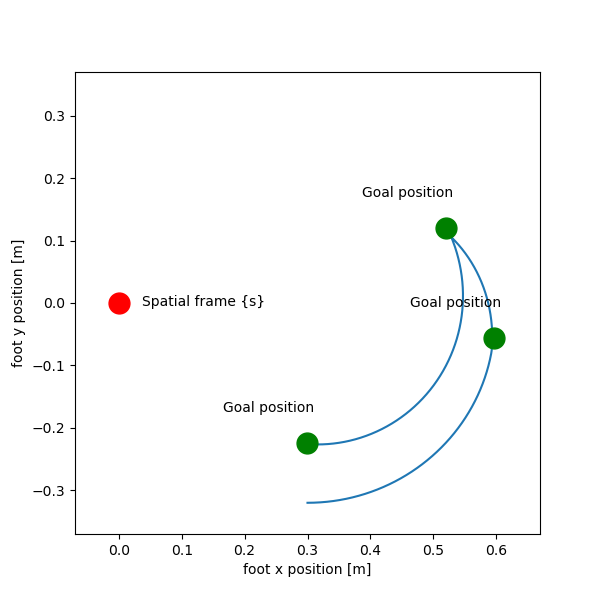

In [7]:
def plot_foot_trajectory(x_pos, y_pos, ball_positions):
    """
    plots the position of the foot in 2D and the position of the spatial frame {s}
    we assume that the time varying x variable is in x_pos and that the y variable is in y_pos
    """
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)
    plt.plot(x_pos,y_pos)
    plt.xlabel('foot x position [m]')
    plt.ylabel('foot y position [m]')
    plt.xlim([-l1-l2+l0-0.05,l0+l1+l2+0.05])
    plt.ylim([-l1-l2-0.05, l1+l2+0.05])
    plt.plot([0],[0],'o',markersize=15,color='r')
    
    for ball in ball_positions:
        plt.plot([ball[0]],[ball[1]],'o',markersize=15,color='g')
        ax.annotate('Goal position', xy=(ball[0]-0.2,0.05+ball[1]), xytext=(30,0), textcoords='offset points')
    ax.annotate('Spatial frame {s}', xy=(-0.03,-0.005), xytext=(30,0), textcoords='offset points')
    


    
# you need to first create x_pos and y_pos variables!    
plot_foot_trajectory(x_pos, y_pos, ball_positions)

<IPython.core.display.Javascript object>


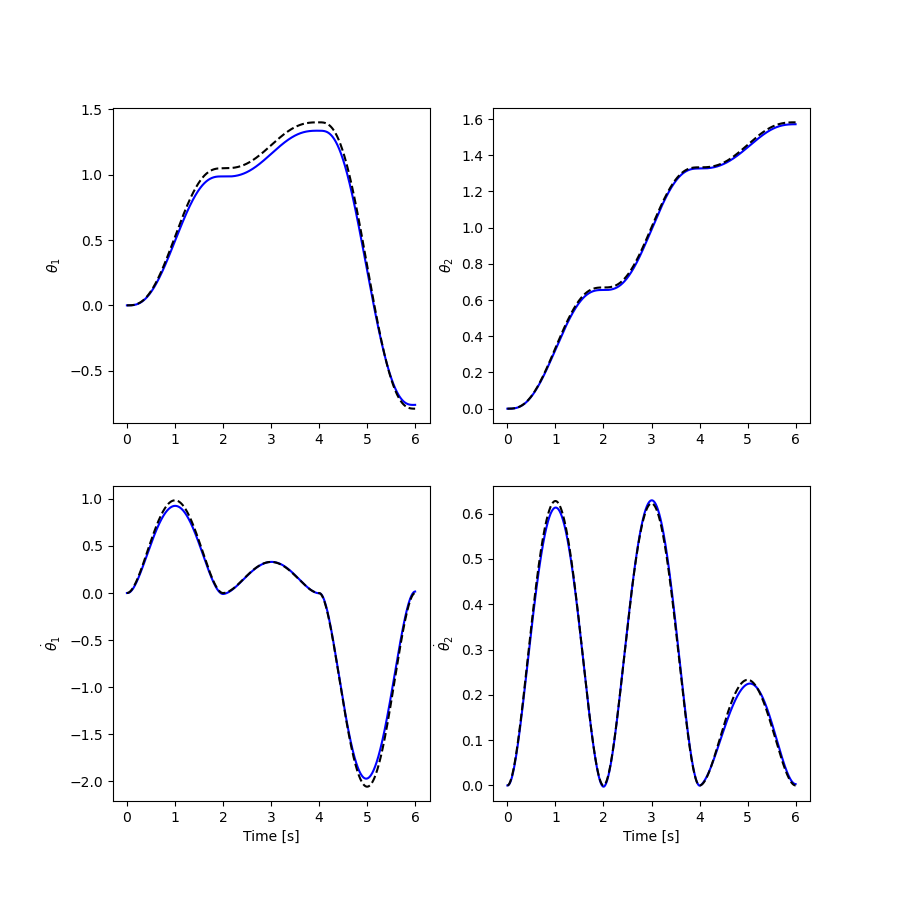

In [8]:
def plot_joint_posvel(time, th, th_des, dth, dth_des):
    fig = plt.figure(figsize=(9,9))
    plt.subplot(2,2,1)
    plt.plot(time, th[:,1], 'b-', time, th_des[:,1], '--k')
    plt.ylabel(r'$\theta_1$')
    plt.subplot(2,2,2)
    plt.plot(time, th[:,2], 'b-', time, th_des[:,2], '--k')
    plt.ylabel(r'$\theta_2$')
    plt.subplot(2,2,3)
    plt.plot(time, dth[:,1], 'b-', time, dth_des[:,1], '--k')
    plt.ylabel(r'$\dot{\theta}_1$')
    plt.xlabel('Time [s]')
    plt.subplot(2,2,4)
    plt.plot(time, dth[:,2], 'b-', time, dth_des[:,2], '--k')
    plt.ylabel(r'$\dot{\theta}_2$')
    plt.xlabel('Time [s]')
    
plot_joint_posvel(time, measured_positions, desired_positions, measured_velocities, desired_velocities)